# Projeto

Este projeto desenvolverá um modelo transformer BERT e o treinará utilizando a tarefa de Masked Language Model (MLM), aplicado ao contexto das músicas brasileiras de forró.

Para isso, foi utilizado o dataset de:

# Transformer

- Encoder: O Encoder recebe a sequência de entrada (por exemplo, uma frase em português) e a processa para criar uma representação vetorial de alta qualidade dessa sequência. Essa representação captura o significado e o contexto de cada palavra em relação às outras palavras da frase.
- Decoder: O Decoder recebe a representação gerada pelo Encoder e a utiliza para gerar uma sequência de saída (por exemplo, a tradução da frase para o inglês).


# Modelo BERT

Bidirectional Encoder Representations from Transformers

1. Bloco transformer com componentes/operacoes Multi-Head Self-Attention, Feed Foward Network e dropout.

2. Customização do modelo, definindo como calcular as metricas que serao utilizadas, neste caso calculando a perda com Sparse Categorical Crossentropy e atualizando com a média da perda.

3. Construção do modelo BERT para o mlm.

4. Callback para a geração de texto para tokens mascarados e apresentação de resultados.

# Masked Language Model

Um Masked Language Model (MLM) é um tipo de modelo de linguagem amplamente utilizado em processamento de linguagem natural.

Durante o treinamento, uma parte dos tokens (palavras ou subpalavras) no texto de entrada é substituída por um token especial de máscara, como "[MASK]". O objetivo do modelo é prever corretamente quais eram os tokens originais que foram mascarados.

Essa estratégia obriga o modelo a aprender contextos ricos e relações entre as palavras, o que é fundamental para o desempenho em diversas tarefas, como análise de sentimentos, tradução, e resposta a perguntas. Modelos famosos que utilizam essa técnica incluem o BERT, que demonstrou ganhos significativos em várias benchmarks de NLP .


## Configuração

In [109]:
import os

os.environ[ "KERAS_BACKEND" ] = "torch"  # or jax, or tensorflow

import keras_hub

import keras
from keras import layers
from keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

In [131]:
import torch

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print( f"Using device: {device}" )

Using device: cpu


In [110]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 16  #32
    LR = 0.0001  #0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

# Carregando os dados

Primeiro, vamos carregar os dados que estão na pasta "aclImbd".

Duas funções serão utilizadas para isso:

- Uma irá criar uma lista contendo o conteúdo dos arquivos.
- A outra ficará responsável por criar um dataframe.

In [111]:
def get_text_list_from_files( files ) -> list[ str ]:
    """
       Esta função irá retornar uma lista contendo todas as frases dos arquivos.
    """
    text_list: list[ str ] = [ ]
    for name in files:
        with open( name, "r", encoding = "utf-8" ) as f:
            # Lê o conteúdo completo do arquivo; se houver várias linhas e desejar cada linha
            # como exemplo separado, use um loop for sobre f.
            text_list.append( f.read() )
    return text_list


def get_data_from_text_files( folder_name ):
    # Arquivos de texto que serão utilizados
    files = glob.glob( f"musicas/{folder_name}/*.txt" )

    # Listas com os textos
    texts: list[ str ] = get_text_list_from_files( files )

    # Criação de um dataframe, com coluna chamada "lyric"
    df = pd.DataFrame( { "lyric": texts } )

    # Sample -> pega uma amostra aleatória
    # len(df) -> do tamanho do df original
    # reset_index -> ao usar sample, o índice original das linhas é mantido
    df = df.sample( len( df ) ).reset_index( drop = True )
    return df


train_df = get_data_from_text_files( "train" )
test_df = get_data_from_text_files( "test" )

# Novidade
print( f"Tamanho do DataFrame de Treino: {len( train_df )}" )
print( f"Tamanho do DataFrame de Teste/Validação: {len( test_df )}" )

# Concatenação dos dataframes para realizar pré-processamento em toda a base
all_data = pd.concat( [ train_df, test_df ], ignore_index = True )


Tamanho do DataFrame de Treino: 1444
Tamanho do DataFrame de Teste/Validação: 361


In [112]:
train_df.head()

,lyric
0,Segue a tua estrada Que eu já te esqueci Quand...
1,Chega mais perto vai quero te encontrar Quero ...
2,Todo amor já lhe dei Você não quis valorizar A...
3,Foi só cruzar o teu olhar com o meu Pra eu ent...
4,Esse rio que passa no meu coração Navega pra m...


In [113]:
import tensorflow as tf


def custom_standardization( input_data ):
    """Normalização de texto. """
    # Converter todas as letras para minúsculas
    lowercase = tf.strings.lower( input_data )

    # Expressão Regular para remover a tag HTML
    stripped_html = tf.strings.regex_replace( lowercase, "<br />", " " )

    # Remover caracteres especiais
    return tf.strings.regex_replace(
            stripped_html,
            "[%s]" % re.escape( "!#$%&'()*+,-./:;<=>?@\^_`{|}~" ),
            ""
    )

## Vetorização de Texto

Para um transformer, a vetorização de um texto é o processo fundamental de transformar o texto bruto em uma representação numérica que o modelo possa entender e processar. Em essência, é como traduzir a linguagem humana para a linguagem matemática que o transformer consegue trabalhar.

Imagine que o transformer é um computador que só entende números. Para que ele consiga ler e compreender um texto, precisamos converter cada palavra (ou parte da palavra) em um conjunto de números. Esse conjunto de números é o que chamamos de vetor.

Aqui está um detalhamento do processo de vetorização para um transformer:

1. Tokenização: O primeiro passo é dividir o texto em unidades menores, chamadas tokens. Um token pode ser uma palavra inteira, parte de uma palavra (subpalavra), ou até mesmo um caractere. Por exemplo, a frase "O gato comeu o rato" poderia ser tokenizada como: ["O", "gato", "comeu", "o", "rato"].

2. Criação do Vocabulário: Em seguida, é criado um vocabulário, que é uma lista de todos os tokens únicos presentes no conjunto de dados de treinamento do modelo. Cada token nesse vocabulário recebe um índice único.

3. Indexação: Cada token no texto de entrada é então mapeado para o seu índice correspondente no vocabulário. Usando o exemplo anterior e supondo um vocabulário, os tokens poderiam ser convertidos em índices como: [10, 25, 50, 10, 75].

4. Embedding: A etapa crucial para transformers é a criação de embeddings. Em vez de simplesmente usar os índices brutos, cada índice é transformado em um vetor denso de números reais. Esse vetor captura o significado semântico e as relações entre as palavras.

    - Word Embeddings: Cada palavra (ou token) é associada a um vetor de baixa dimensionalidade (por exemplo, 512 ou 768 dimensões). Palavras com significados semelhantes tendem a ter vetores próximos no espaço vetorial. Por exemplo, os vetores para "gato" e "felino" provavelmente estarão mais próximos do que os vetores para "gato" e "carro".

    - Positional Embeddings: Transformers também precisam entender a ordem das palavras em uma frase. Para isso, são adicionados embeddings posicionais aos word embeddings. Esses vetores codificam a posição de cada token na sequência, permitindo que o modelo diferencie entre "o gato comeu o rato" e "o rato comeu o gato".

5. Input para o Transformer: Os vetores resultantes (a soma dos word embeddings e positional embeddings para cada token) são então alimentados como entrada para as diferentes camadas do transformer (como as camadas de atenção).

In [114]:
def get_vectorize_layer( texts: list[ str ], vocab_size: int, max_seq: int, special_tokens: list = [ "[MASK]" ] ):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence length.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """

    # Criação da camada de TextVectorization
    vectorize_layer = TextVectorization(
            max_tokens = vocab_size,  # Define o tamanho máximo do vocabulário
            output_mode = "int",  # Define que a saída deve ser uma sequência de números inteiros
            standardize = custom_standardization,  # Aplicar função de pré-processamento
            output_sequence_length = max_seq,  # Garantir que toda sequência de saída tenha comprimento max_seq
    )

    # todo Mostrar um exemplo

    # Adaptação aos textos de entrada
    # A camada "sabe" como mapear palavras para números inteiros, com base nas entradas
    vectorize_layer.adapt( texts )

    # Obtém o vocabulário aprendido
    vocab = vectorize_layer.get_vocabulary()

    # Por padrão, o TextVectorization coloca "" (para padding, índice 0) e "[UNK]" (para palavras desconhecidas,
    # índice 1) no início do vocabulário.

    # Pegando uma porção do vocabulário:
    # - Ignorando "" e "[UNK]"
    # - Pega quase tudo, deixando espaço suficiente para special_tokens
    vocab = vocab[ 2: vocab_size - len( special_tokens ) ] + special_tokens

    # Atualiza o vocabulário da camada
    vectorize_layer.set_vocabulary( vocab )

    # Retorna a camada
    return vectorize_layer

In [115]:
# Novidade
# Pega os textos APENAS do treino para adaptar o vetorizador
train_texts = train_df.lyric.values.tolist()

# Pegando a camada de vetorização
vectorize_layer = get_vectorize_layer(
        train_texts,
        config.VOCAB_SIZE,
        config.MAX_LEN,
        special_tokens = [ "[mask]" ],
)

# Processamento de um novo dado: "[mask]"
# - Aplica a função de pré-processamento
# - Divide em token, pega seu id e cria uma sequência de comprimento config.MAX_LEN
# - Converte o resultado para um array NumPy
# - Pega o id do "[mask]"
mask_token_id = vectorize_layer( [ "[mask]" ] ).cpu().numpy()[ 0 ][ 0 ]

In [116]:
def encode( texts ):
    """ Retorna um array NumPy das sequências numéricas dos textos de entrada."""
    # Criação das sequências numéricas para os textos de entrada
    encoded_texts = vectorize_layer( texts )
    # Retorna as sequências como um array NumPy
    return encoded_texts.cpu().numpy()

### Mascaramento de Texto

Em essência, o mascaramento envolve ocultar aleatoriamente algumas das palavras (ou tokens) em uma sequência de texto de entrada. O objetivo é fazer com que o modelo aprenda a prever as palavras que foram mascaradas, com base no contexto das palavras vizinhas não mascaradas.

Imagine a frase: "O gato está dormindo no tapete."

No processo de mascaramento, poderíamos aleatoriamente escolher algumas palavras para ocultar, substituindo-as por um token especial, geralmente chamado [MASK]. Por exemplo, a frase poderia se tornar:

"O [MASK] está dormindo no [MASK]."

O modelo de linguagem, durante o treinamento, receberia essa versão mascarada da frase como entrada e teria como objetivo prever as palavras originais que foram substituídas por [MASK]. Neste caso, o modelo deveria aprender a prever "gato" para o primeiro [MASK] e "tapete" para o segundo.

In [117]:
def get_masked_input_and_labels( encoded_texts ):
    # Cria um array NumPy com o mesmo tamanho de encoded_texts preenchido com números aleatórios entre 0 e 1
    # Vai comparar cada um dos números com 0.15, se for maior ou igual, será True, do contrário, será False
    # inp_mask será um array de booleanos de mesmo tamanho que encoded_texts
    inp_mask = np.random.rand( *encoded_texts.shape ) < 0.15

    # Não deixa realizar o mascaramento em tokens especiais
    inp_mask[ encoded_texts <= 2 ] = False

    # Cria um array com o mesmo tamanho de encoded_texts preenchido com o valor -1
    # O valor -1 é usado para indicar que esses tokens não são alvos para a previsão durante o treinamento
    labels = -1 * np.ones( encoded_texts.shape, dtype = int )

    # Para as posições no array qye são True em inp_mask, os valores dos IDs dos tokens são atribuídos a labels
    # Assim, labels terá os IDs dos tokens que foram mascarados, e o modelo terá que prever esses IDs
    labels[ inp_mask ] = encoded_texts[ inp_mask ]

    # Cria uma cópia de encoded_texts
    encoded_texts_masked = np.copy( encoded_texts )

    # Cria uma nova máscara booleana
    # Ela é True apenas nas posições onde inp_mask também é True E um novo número aleatório gerado para
    # essa posição é menor que 0.9
    # Apenas 90% dos 15% dos tokens selecionados para mascaramente, serão, de fato, mascarados
    inp_mask_2mask = inp_mask & (np.random.rand( *encoded_texts.shape ) < 0.90)

    # Atualizando posições onde inp_mask_2mask são True para a máscara
    encoded_texts_masked[ inp_mask_2mask ] = mask_token_id

    # Cria uma nova máscara booleana
    # Ela é True apenas nas posições onde inp_mask_2mask também é True E um novo número aleatório gerado para
    # essa posição é menor que 1/9
    # 1/9 dos 90% serão tokens aleatórios
    inp_mask_2random = inp_mask_2mask & (np.random.rand( *encoded_texts.shape ) < 1 / 9)

    # Nas posições onde inp_mask_2random é True, o token em encoded_texts_masked será um token aleatório
    # Gera um array de números aleatórios partindo de 3 e indo até antes de mask_token_id
    # Começou em 3 porque as primeiras posições foram excluídas
    encoded_texts_masked[ inp_mask_2random ] = np.random.randint(
            3, mask_token_id, inp_mask_2random.sum()
    )

    # Cria um array de mesmo tamanho que labels preenchido com 1
    sample_weights = np.ones( labels.shape )

    # Nas posições dos tokens que têm -1, o valor em sample_weights será 0
    # Isso significa que a perda durante o treinamento será calculada apenas para os tokens
    # que foram realmente mascarados
    sample_weights[ labels == -1 ] = 0

    # Cria uma cópia de encoded_texts
    y_labels = np.copy( encoded_texts )

    # A versão da entrada com alguns tokens substituídos por [MASK] ou por tokens aleatórios
    # Os tokens originais da entrada, que servem como os rótulos para o treinamento
    # Um array de pesos que indica quais posições em y_labels devem ser consideradas no cálculo da perda
    return encoded_texts_masked, y_labels, sample_weights

## Codificação e Datasets

1. Classificação de Sentimentos: Cria datasets de treinamento e teste (train_classifier_ds e test_classifier_ds) onde as revisões são codificadas e emparelhadas com seus rótulos de sentimento.

2. Modelo de Linguagem Mascarada: Cria um dataset (mlm_ds) para treinar um modelo a prever palavras mascaradas em um conjunto de todas as revisões.

In [118]:
# Codificação das letras
x_train = encode( train_df.lyric.values )
x_test = encode( test_df.lyric.values )

In [119]:
# Mascaramento das letras
x_train_masked, y_train_labels, train_sample_weights = get_masked_input_and_labels(
        x_train
)
x_val_masked, y_val_labels, val_sample_weights = get_masked_input_and_labels(
        x_test
)

In [120]:
# Criação dos Datasets TensorFlow

# Dataset de Treino para MLM
mlm_train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train_masked, y_train_labels, train_sample_weights)
)
# Embaralha e agrupa em lotes
mlm_train_ds = mlm_train_ds.shuffle( 1000 ).batch( config.BATCH_SIZE ).prefetch( tf.data.AUTOTUNE )

# Dataset de Teste para MLM
mlm_val_ds = tf.data.Dataset.from_tensor_slices(
        (x_val_masked, y_val_labels, val_sample_weights)
)
# APENAS agrupa em lotes (não precisa embaralhar teste)
mlm_val_ds = mlm_val_ds.batch( config.BATCH_SIZE ).prefetch( tf.data.AUTOTUNE )


In [121]:
# Aplica a codificação em toda a base
# x_all_review = encode( all_data..values )

# Passa a codificação da base para realizar o mascaramento dos dados

# x_masked_train: As revisões com alguns tokens mascarados (substituídos por um token especial ou por tokens aleatórios).
#   Esta será a entrada para o modelo de linguagem mascarada.

# y_masked_labels: Os rótulos para a tarefa de mascaramento.

# sample_weights: Pesos que indicam quais tokens devem ser considerados no cálculo da perda
# x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
#         x_all_review
# )

# Cria um dataset onde, cada elemento será uma tupla:
# - As reviews mascaradas
# - Rótulos originais
# - Pesos de amostra
mlm_ds = tf.data.Dataset.from_tensor_slices(
        (x_masked_train, y_masked_labels, sample_weights)
)

# Embaralha o dataset e agrupa em lotes
mlm_ds = mlm_ds.shuffle( 1000 ).batch( config.BATCH_SIZE )

# Treinamento do modelo BERT

In [122]:
def bert_module( query, key, value, i ):

    #Fazer uma "self-attention" com multiplas cabeças
    #self attention e uma maneira do modelo enteder as relacoes de uma sequencia de palavras
    #por ter mais de 1 cabeça permite notar essas relacoes em diferentes partes do texto
    attention_output = layers.MultiHeadAttention(
            num_heads = config.NUM_HEAD,
            key_dim = config.EMBED_DIM // config.NUM_HEAD,
            name = "encoder_{}_multiheadattention".format( i ),
    )( query, key, value )

    #Dropout para ajudar na regularizacao (evitar overfitting)
    attention_output = layers.Dropout( 0.1, name = "encoder_{}_att_dropout".format( i ) )(
            attention_output
    )

    #Layer normalization da atencao que foi calculada e da entrada original
    #serve para garantir o processo de informacao de maneira consistente, ajudando na performance e eficiencia
    attention_output = layers.LayerNormalization(
            epsilon = 1e-6, name = "encoder_{}_att_layernormalization".format( i )
    )( query + attention_output )

    # Feed-forward layer, serve para que informacoes em estagios tadios do processamento sejam
    #enviados para estagios mais iniciais
    ffn = keras.Sequential(
            [
                layers.Dense( config.FF_DIM, activation = "relu" ),  #expande  dimensao para FF_DIMe ativacao ReLU
                layers.Dense( config.EMBED_DIM ),  #volta para a dimensao original
            ],
            name = "encoder_{}_ffn".format( i ),
    )

    #aplicacao de dropout novamente
    ffn_output = ffn( attention_output )
    ffn_output = layers.Dropout( 0.1, name = "encoder_{}_ffn_dropout".format( i ) )(
            ffn_output
    )

    #layer normalization novamente com a saida da camada de atencao
    sequence_output = layers.LayerNormalization(
            epsilon = 1e-6, name = "encoder_{}_ffn_layernormalization".format( i )
    )( attention_output + ffn_output )

    #o resultado possui a mesma dimensao da entrada porem com representacoes melhores
    #mesmos dados porem enriquecidos de contexto
    return sequence_output


In [123]:
#Funcao de perda de entropia cruzada esparsa
#usada quando tem duas ou mais classes de label
loss_fn = keras.losses.SparseCategoricalCrossentropy( reduction = None )
#media dos valores de perda ao longo do treinamento
loss_tracker = keras.metrics.Mean( name = "loss" )


#esta classe serve para calcular as metricas e a perda de maneira customizada
#assim temos um controle maior do treinamento
class MaskedLanguageModel( keras.Model ):

    def compute_loss( self, x = None, y = None, y_pred = None, sample_weight = None ):
        #ja que na funcao de perda nao tem reducao vamos ter um valor de perda pra cada exemplo
        #entao o fazemos com que a soma total seja o que sera otimizada
        loss = loss_fn( y, y_pred, sample_weight )
        loss_tracker.update_state( loss, sample_weight = sample_weight )
        return keras.ops.sum( loss )

    def compute_metrics( self, x, y, y_pred, sample_weight ):
        # Retorna um dicionario com a perda media do loss_tracker
        return { "loss": loss_tracker.result() }

    @property
    def metrics( self ):
        #este serve para que nao seja necessario o reset manual das metricas
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [ loss_tracker ]

In [124]:
def create_masked_language_bert_model():
    #configura a camada de entrada para que seja uma lista de tokens INT
    inputs = layers.Input( (config.MAX_LEN,), dtype = "int64" )

    #converte os IDs dos tokens em vetores
    #cava vetor tera  dimensao de EMBED_DIM
    word_embeddings = layers.Embedding(
            config.VOCAB_SIZE, config.EMBED_DIM, name = "word_embedding"
    )( inputs )

    #cria a informacao adicional das posicoes dos tokens para o modelo usando a bibliote do keras_hub
    position_embeddings = keras_hub.layers.PositionEmbedding(
            sequence_length = config.MAX_LEN
    )( word_embeddings )

    #combina as duas informacoes criadas, a de semantica de a de posicao
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings

    #para cada camada se aplica o bert, um bloco transformer contendo Multi-Head Self-Attention e Feed-Forward Network
    for i in range( config.NUM_LAYERS ):
        encoder_output = bert_module( encoder_output, encoder_output, encoder_output, i )

    #camada de classificacao para o mlm, transformando a saída do encoder em predições de tokens
    #a função de ativação softmax transforma as saídas brutas da rede neural em um vetor de probabilidades
    mlm_output = layers.Dense( config.VOCAB_SIZE, name = "mlm_cls", activation = "softmax" )(
            encoder_output
    )

    #criar a instancia da classe mlm que ja definimos
    mlm_model = MaskedLanguageModel( inputs, mlm_output, name = "masked_bert_model" )

    #otimizacao usando "Adam" e compilacao
    optimizer = keras.optimizers.Adam( learning_rate = config.LR )
    mlm_model.compile( optimizer = optimizer )
    return mlm_model


#mapeamento de ID para token e vice versa para facilitar interpretacao dos dados
id2token = dict( enumerate( vectorize_layer.get_vocabulary() ) )
token2id = { y: x for x, y in id2token.items() }

In [125]:
#por herdar keras.callbacks.Callback pode ser usada durante o treinamento
class MaskedTextGenerator( keras.callbacks.Callback ):
    def __init__( self, sample_tokens, top_k = 5 ):
        self.sample_tokens = sample_tokens  #exemplo de entrada
        self.k = top_k  #quantos candidatos serao considerados para cada mascara

    #sequencia de tokens para uma string
    def decode( self, tokens ):
        return " ".join( [ id2token.get( int( t ), "[UNK]" ) for t in tokens if t != 0 ] )

    #converte o seu ID para seu token correspondente
    def convert_ids_to_tokens( self, id ):
        return id2token[ id ]

    #executado ao final de cada epoca
    def on_epoch_end( self, epoch, logs = None ):
        #recebe as previsoes do modelo para o exemplo fornecido
        prediction = self.model.predict( self.sample_tokens )

        #procura onde esta os tokens de mascara
        masked_index = np.where( self.sample_tokens == mask_token_id )
        masked_index = masked_index[ 1 ]

        #pega as probabilidades de predicao para os tokens mascarados
        mask_prediction = prediction[ 0 ][ masked_index ]

        #ordena e armazena em values os top_k (5 neste caso) maiores probabilidades
        top_indices = mask_prediction[ 0 ].argsort()[ -self.k: ][ ::-1 ]
        values = mask_prediction[ 0 ][ top_indices ]

        #para cada entre os top candidatos cria uma copia e substitui
        #depois printa o texto original e os resultados com as palavras preditas junto com a probabilidade e token
        for i in range( len( top_indices ) ):
            p = top_indices[ i ]
            v = values[ i ]
            tokens = np.copy( sample_tokens[ 0 ] )
            tokens[ masked_index[ 0 ] ] = p
            result = {
                "input_text": self.decode( sample_tokens[ 0 ].numpy() ),
                "prediction": self.decode( tokens ),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens( p ),
            }
            pprint( result )


#converte o exemplo para uma sequencia de IDs e instacia com o callback com o exemplo, este sera usado nas predicoes no final de cada epoca
sample_tokens = vectorize_layer( [ "Estou com muita [mask] de você" ] )

# Caso sample_tokens seja um tensor PyTorch, mova para a CPU antes de passar para o callback
if isinstance( sample_tokens, torch.Tensor ):
    generator_callback = MaskedTextGenerator( sample_tokens.cpu().numpy()
                                              )  # Movendo para a CPU e convertendo para numpy
else:
    generator_callback = MaskedTextGenerator( sample_tokens )

#cria o modelo bert pra o mlm e resume com summary()
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add_15[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_15[0][0],     │
│                     │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 256, 128)  │          0 │ add_15[0][0],     │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
# Calcula os passos por época para treino e validação
# Usar len(train_df) e len(test_df) para os cálculos
train_steps_per_epoch: int = len( train_df ) // config.BATCH_SIZE
val_steps_per_epoch: int = len( test_df ) // config.BATCH_SIZE

print( f"Passos por época (Treino): {train_steps_per_epoch}" )
print( f"Passos por época (Validação): {val_steps_per_epoch}" )

# Treina o modelo usando os datasets separados e validation_data
history = bert_masked_model.fit(
        mlm_train_ds,
        validation_data = mlm_val_ds,  # Passa o dataset de validação
        epochs = 5,  # Ou o número de épocas desejado
        steps_per_epoch = train_steps_per_epoch,  # Passos para treino
        validation_steps = val_steps_per_epoch,  # Passos para validação
        callbacks = [ generator_callback ]  # Mantém o callback para ver exemplos
)

bert_masked_model.save( "bert_mlm.keras" )
print( "\nTreinamento concluído e modelo salvo!" )

Passos por época (Treino): 90
Passos por época (Validação): 22
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('a'),
 'prediction': 'estou com muita a de você',
 'probability': np.float32(0.00028247133)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('de'),
 'prediction': 'estou com muita de de você',
 'probability': np.float32(0.000272462)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('eu'),
 'prediction': 'estou com muita eu de você',
 'probability': np.float32(0.00026491968)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('você'),
 'prediction': 'estou com muita você de você',
 'probability': np.float32(0.00026002826)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('não'),
 'prediction': 'estou com muita não de você',
 'probability': np.float32(0.00025612328)}
9

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('a'),
 'prediction': 'estou com muita a de você',
 'probability': np.float32(0.00029032005)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('de'),
 'prediction': 'estou com muita de de você',
 'probability': np.float32(0.00028030528)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('eu'),
 'prediction': 'estou com muita eu de você',
 'probability': np.float32(0.0002722427)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('você'),
 'prediction': 'estou com muita você de você',
 'probability': np.float32(0.0002664765)}
{'input_text': 'estou com muita [mask] de você',
 'predicted mask token': np.str_('não'),
 'prediction': 'estou com muita não de você',
 'probability': np.float32(0.00026277543)}
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - loss: 9.1575 - val_loss: 8.9769

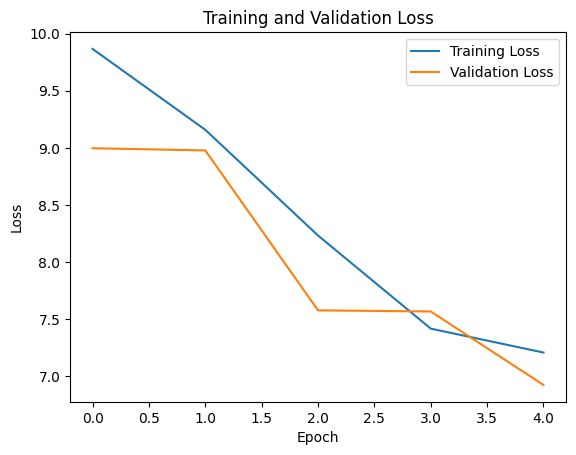

In [127]:
# Plotar histórico de loss
import matplotlib.pyplot as plt

plt.plot( history.history[ 'loss' ], label = 'Training Loss' )
plt.plot( history.history[ 'val_loss' ], label = 'Validation Loss' )  # Keras nomeia a loss de validação como 'val_loss'
plt.title( 'Training and Validation Loss' )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.legend()
plt.show()

In [128]:
# Retoma o treinamento
from tensorflow.keras.models import load_model

# Carrega o modelo salvo
if 0:
    bert_mlm_model = load_model( "bert_mlm_musicas.keras" )
    bert_mlm_model.fit( mlm_ds.repeat(), epochs = 5, steps_per_epoch = steps, callbacks = [ generator_callback ] )

# Predição de Frases

Utilização do modelo treinado para realizar a predição de novas frases.

In [129]:
import pandas as pd
import numpy as np


# Função para prever o token mascarado e mostrar top K predições
def predict_masked_token( text_with_mask: str, model, vectorize_layer, id2token, top_k = 5 ):
    """
    Prevê o token mascarado em uma frase e retorna as top K previsões com probabilidades.

    Args:
        text_with_mask (str): A frase de entrada contendo exatamente um token '[mask]'.
        model (keras.Model): O modelo treinado (MLM).
        vectorize_layer (TextVectorization): A camada de vetorização JÁ ADAPTADA.
        id2token (dict): Dicionário mapeando ID para token.
        top_k (int): Quantidade de melhores previsões a serem mostradas.

    Returns:
        pandas.DataFrame: DataFrame com as top K previsões, tokens e probabilidades.
                         Retorna None se '[mask]' não for encontrado ou mais de um for encontrado.
    """
    # 1. Vetorizar a frase de entrada
    #    O reshape [1, -1] adiciona a dimensão do batch (lote de tamanho 1)
    sample_tokens = vectorize_layer( [ text_with_mask ] )  # Não precisa de .numpy() aqui para predict

    # Verifica se a vetorização retornou algo e se tem o formato esperado
    if sample_tokens is None or sample_tokens.shape[ 0 ] == 0:
        print( "Erro: A vetorização não produziu uma saída válida." )
        return None

    # 2. Encontrar o índice do token [mask]
    #    `.numpy()` converte o tensor para numpy array para usar np.where
    #    Pega o id do token de máscara global que definimos antes
    masked_index_tuple = np.where( sample_tokens.numpy()[ 0 ] == mask_token_id )

    # Verifica se encontrou o token de máscara e se é apenas um
    if len( masked_index_tuple[ 0 ] ) != 1:
        print(
                f"Erro: Esperado exatamente um token '[mask]' na frase vetorizada, mas encontrado(s) {len( masked_index_tuple[ 0 ] )}."
        )
        print( f"Frase vetorizada: {sample_tokens.numpy()[ 0 ]}" )
        print( f"ID esperado para [mask]: {mask_token_id}" )
        # Tenta decodificar para ajudar a depurar
        try:
            decoded_tokens = [ id2token.get( int( t ), "[UNK]" ) for t in sample_tokens.numpy()[ 0 ] if t != 0 ]
            print( f"Tokens decodificados: {' '.join( decoded_tokens )}" )
        except Exception as e:
            print( f"Não foi possível decodificar os tokens: {e}" )
        return None

    masked_index = masked_index_tuple[ 0 ][ 0 ]  # Pega o índice escalar

    # 3. Fazer a predição com o modelo
    prediction = model.predict( sample_tokens )

    # 4. Extrair as probabilidades para a posição mascarada
    #    prediction[0] -> batch de tamanho 1
    #    prediction[0][masked_index] -> probabilidades para o token na posição mascarada
    mask_prediction_probabilities = prediction[ 0 ][ masked_index ]

    # 5. Encontrar os top K índices e suas probabilidades
    #    argsort() retorna os índices que ordenariam o array (do menor para o maior)
    #    [-top_k:] pega os K maiores índices
    #    [::-1] inverte para ter do maior para o menor
    top_indices = mask_prediction_probabilities.argsort()[ -top_k: ][ ::-1 ]
    top_probabilities = mask_prediction_probabilities[ top_indices ]

    # 6. Converter os IDs dos tokens previstos para palavras
    top_tokens = [ id2token.get( idx, "[UNK]" ) for idx in top_indices ]

    # 7. Criar e retornar um DataFrame com os resultados
    results_df = pd.DataFrame( {
        "Token Previsto": top_tokens,
        "Probabilidade": top_probabilities
    }
    )

    print( f"\nPredições para: '{text_with_mask}'" )
    return results_df

In [130]:
frase_teste_1 = "Eu gosto de ouvir [mask] no rádio."
resultados_df_1 = predict_masked_token( frase_teste_1, bert_masked_model, vectorize_layer, id2token, top_k = 10 )

if resultados_df_1 is not None:
    print( resultados_df_1.to_string( index = False ) )  # .to_string para melhor formatação no print

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Predições para: 'Eu gosto de ouvir [mask] no rádio.'
Token Previsto  Probabilidade
            de       0.010039
            eu       0.009834
           não       0.009456
             o       0.009189
             a       0.009171
          você       0.008198
             e       0.007958
           pra       0.007226
            me       0.007048
             é       0.006221
